In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

In [17]:
# set working directory
os.chdir("/Users/jasonchan/Documents/DataProjects")

# read in stop data
stops = pd.read_csv("WI-clean.csv", parse_dates = ['stop_date'], low_memory = False)
# read in county segregation data
seg = pd.read_csv("WI_segregation.csv")

# drop rows where driver race is not specified
stops = stops[stops.driver_race.notnull()]

In [18]:
# change search_conducted column to int type
stops['search_conducted'] = stops['search_conducted'] * 1

# change contraband_found column to int type
stops['contraband_found'] = stops['contraband_found'] * 1

# change is_arrested to int type 
stops['is_arrested'] = stops['is_arrested'] * 1

# change drugs_related_stop to int type
stops['drugs_related_stop'] = stops['drugs_related_stop'] * 1

## apply some lambda function to do above

# change stop_time to datetime
stops['stop_time'] = pd.to_datetime(stops['stop_time'], format='%H:%M')

# change location raw to str
stops['location_raw'] = stops['location_raw'].apply(str)

# change search_conducted values to int type
stops['search_conducted'] = stops['search_conducted'].astype(int)

In [19]:
minorities = ['Black', 'Hispanic']

# stops where search was conducted and contrabound was found
successful_stops = stops.loc[stops['contraband_found'] == 1]

# minority stops
minority_stops = stops.loc[stops['driver_race'].isin(minorities)]

# white stops
white_stops = stops.loc[stops['driver_race'] == 'White']

# hit rate among minorities
minority_searches = stops.loc[(stops['driver_race'].isin(minorities)) & stops['search_conducted'] == 1] # minority stops where search was conducted
successful_minority_stops = successful_stops.loc[successful_stops['driver_race'].isin(minorities)] # minority stops where contraband was found
minority_hit = successful_minority_stops.shape[0] / minority_searches.shape[0] # minority hit rate 

# hit rate among whites
white_searches = stops.loc[(stops['driver_race'] == 'White') & stops['search_conducted'] == 1]
successful_white_stops = successful_stops.loc[successful_stops['driver_race'] == 'White']
white_hit = successful_white_stops.shape[0] / white_searches.shape[0] # white hit rate


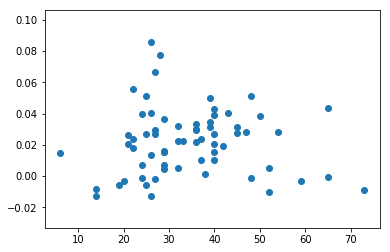

In [126]:
# remove counties with less than 1000 observations
county_stops_group = stops.groupby('location_raw').filter(lambda x: len(x) >= 1000)
# obtain observation counts for each county
county_stops = county_stops_group.groupby('location_raw').size().reset_index(name='counts')
# change column name of 'location_raw' to 'county'
county_stops.columns = ['county', 'count']

# Do more segregated counties have larger disparities in search rates between blacks and whites?

# calculate difference in search rates between whites and minorities per county
def stop_rate(county):
    minority_rate = minority_searches.loc[minority_searches['location_raw'] == county].shape[0] / minority_stops.loc[minority_stops['location_raw'] == county].shape[0]
    white_rate = white_searches.loc[white_searches['location_raw'] == county].shape[0] / white_stops.loc[white_stops['location_raw'] == county].shape[0]
    return(minority_rate - white_rate)

# stop rates for every county
stop_rates = county_stops['county'].apply(lambda x: stop_rate(x))
# append to county_stops column
county_stops['stop_rates'] = stop_rates

# merge county and segregation dataframe
county_seg = pd.merge(county_stops, seg, how = 'inner', on = 'county')
# remove rows with NaN
county_seg = county_seg.dropna()

# plot segregation index and stop_rates
plt.scatter(x = county_seg['segregation'], y = county_seg['stop_rates'])

# do more segregated areas search minorities more? 

Search Classification

Data Cleaning and PreProcessing

In [6]:
from datetime import datetime
from sklearn.model_selection import train_test_split

# Encoding counties

# create copy of stops dataframe
stops_copy = stops.copy(deep = True)

# dummy encode counties
counties = pd.Series(list(stops_copy['location_raw']))
counties_enc = pd.get_dummies(counties)

# dummy encode driver race
race = pd.Series(list(stops_copy['driver_race']))
race_enc = pd.get_dummies(race)

# encode driver gender
gender_enc = stops_copy['driver_gender'].map(dict(F = 0, M = 1))

# Feature extraction
# day of week
day_of_week = lambda x: x.weekday()
stops_copy['day_of_week'] = stops_copy['stop_date'].map(day_of_week)
# dummy encode day of the week
dotw = pd.Series(list(stops_copy['day_of_week']))
dotw_enc = pd.get_dummies(dotw)
# rename columns to days of the week
dotw_enc.columns = ['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun']

# year
stops_copy['year'] = stops_copy['stop_date'].dt.year 

# month
stops_copy['month'] = stops_copy['stop_date'].dt.month
# dummy encode month
month = pd.Series(list(stops_copy['month']))
month_enc = pd.get_dummies(month)
# rename columns to months
month_enc.columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# hour
hour = stops_copy['stop_time'].dt.hour
# minute
minute = stops_copy['stop_time'].dt.minute

# apply sin and cosin transformation to hour column
hourfloat = hour + minute/60
stops_copy['hour_x']= np.sin(2.*np.pi*hourfloat/24.)
stops_copy['hour_y']= np.cos(2.*np.pi*hourfloat/24.)

# keep relevant non-encoded columns
stops_enc = stops_copy.loc[:, ['search_conducted', 'hour_x', 'hour_y']]

# concatenate encoded dataframes to stops dataframe
stops_enc = pd.concat([stops_enc, gender_enc, race_enc], axis = 1, ignore_index = False)

# remove any rows with missing values
stops_enc = stops_enc.dropna()
stops_enc.head()

# split into train and test set, stratify
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.25, random_state = 0, stratify = y)


NameError: name 'train_test_split' is not defined

Model Construction


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# set random seed
np.random.seed(0)

# shuffle dataset
stops_enc_samp = stops_enc.sample(frac = 1)

# split features and target variable
y = stops_enc_samp['search_conducted']
x = stops_enc_samp.drop(['search_conducted'], axis = 1)

# set parameters
parameters = {'bootstrap': True,
             'min_samples_leaf': 3,
             'n_estimators': 50,
             'min_samples_split': 10,
             'max_features': 'sqrt',
             }

# define model
rf_model = RandomForestClassifier(**parameters)


# fit model
rf_fit = rf_model.fit(train_x, train_y)

# Cross validated grid search
param_grid = {'n_estimators': [50,100],
             'max_features': ['auto', 'log2']}

CV_rfc = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv = 10)
CV_rfc.fit(test_x, test_y)
print(CV_rfc.best_params_)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import scikitplot as skplt


# randomforest predictions as probabilities
rf_probs = rf_fit.predict_proba(test_x)

# ROCR cuve, AUC
skplt.metrics.plot_roc(test_y, rf_probs)
plt.show()

# Precision-Recall Curve

skplt.metrics.plot_precision_recall(test_y, rf_probs)
plt.show()

# confusion matrix
confusion_matrix(test_y, rf_preds)



In [ ]:

# feature importance
pd.DataFrame(rf_model.feature_importances_,
             index = train_x.columns,
             columns = ['importance']).sort_values('importance', ascending = False)

In [ ]:
# SVM implementation
from sklearn import svm

# create model
svm_model = svm.SVC(kernel = 'linear')

# fit model
svm_fit = svm_model.fit(train_x, train_y)

# predictions
svm_preds = svm_fit.predict(test_x)

# confusion matrix
confusion_matrix(test_y, svm_preds)

In [ ]:
# XGboost
from xgboost import XGBClassifier

# model
xg_model = XGBClassifier()

# fit model
xg_fit = xg_model.fit(train_x, train_y)

# predicitons
xg_preds =xg_fit.predict(test_x)

# confusion matrix
confusion_matrix(test_y, xg_preds)

# grid search
n_estimators = range(50, 400, 50)
xg_param_grid = dict(n_estimators = n_estimators)
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 7)
CV_xgb = GridSearchCV(xg_model, xg_param_grid, scoring = 'neg_log_loss', n_jobs = -1, cv =kfold)
CV_xgb_result = CV_xgb.fit(test_x, test_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
print("%f (%f) with: %r" % (mean, stdev, param))
# plot
pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators.png')

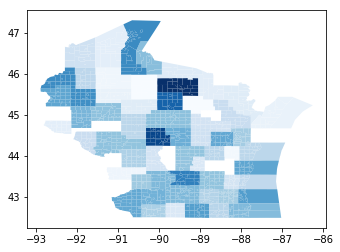

In [144]:
# Geopandas visualization 
import geopandas as gpd

# read in shape file
map_df = gpd.read_file('tl_2015_55_cousub.shp')
# read in counties file
counties_num = pd.read_csv('WI_counties.csv')

map_df['county_id'] = map_df['COUNTYFP'].astype(int)

# merge counties_seg and WI_counties, obtaining numerical identifiers for each county
wi_counties = pd.merge(counties_num, county_seg, how = 'inner', on = 'county')

# change county_id type to int
wi_counties['county_id'] = wi_counties['county_id'].astype(int)

# drop unnecessary columns
map_df = map_df[['county_id', 'geometry']]

# merge wi_counties with shape dataframe
merged = pd.merge(map_df, wi_counties, on = 'county_id', how = 'left')

# rename segregation column
merged.rename(columns={'segregation':'seg_index'}, inplace=True)

# remove all rows with NaNs
merged = merged.dropna()

# create chloropeth
merged.plot(column = 'stop_rates', cmap = 'Blues', linewidth = 0.8)
